In [1]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from lib.dataset.cataracts_dataset import CATARACTSDataset
from lib.model.ddim import DDIM
from lib.model.conditional_unet import ConditionalUNet
from lib.utils.pre_train import get_configs

In [2]:
DATA_PATH = '/media/yannik/samsung_data_ssd/data/CATARACTS-videos-processed/'
LOG_PATH = 'results/ddpm/2023.02.21 15_46_53/'
TARGET_PATH = os.path.join(LOG_PATH, "eval/gen_samples2/")
DEV = 'cuda'
data_conf, model_conf, diffusion_conf, train_conf = get_configs(LOG_PATH + "config.yaml")
diffusion_conf['NUM_SAMPLE_TIMESTEPS'] = 200  # /1000
os.makedirs(TARGET_PATH, exist_ok=True)
BATCH_SIZE = 1
STEPS = 1  # 30000//BATCH_SIZE
TARGET_SHAPE = (3, 270, 480)
print(f"Avail. GPUs: ", torch.cuda.device_count())

Avail. GPUs:  1


In [4]:
test_ds = CATARACTSDataset(
    root=DATA_PATH,
    resize_shape=eval(data_conf['SHAPE'])[1:],
    normalize=eval(data_conf['NORM']),
    mode='test',
    frame_step=data_conf['FRAME_STEP'],
    sample_img=False
)
# TODO: Weighted sampling / sampling from p(toolset|phase)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=8,
                     drop_last=True, shuffle=True, pin_memory=False)
print(f"{len(test_ds)} test samples")

8873 test samples


In [5]:
diffusion = DDIM(diffusion_config=diffusion_conf, model_config=model_conf, device=DEV)
m = ConditionalUNet(data_config=data_conf,
                    model_config=model_conf,
                    diffusion_config=diffusion_conf,
                    num_phase_labels=test_ds.num_phases_classes,
                    num_semantic_labels=test_ds.num_tool_classes).to(DEV)
m = torch.nn.DataParallel(m, device_ids=['cuda:0']) if not DEV == 'cpu' else m
m.load_state_dict(torch.load(LOG_PATH + "ckpt.pth", map_location='cpu')[0])
m.eval()

DataParallel(
  (module): ConditionalUNet(
    (temb): Module(
      (dense): ModuleList(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (temb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kern

In [6]:
for i, (_, _, _, phase_label, tool_label) in enumerate(tqdm(test_dl)):
    with torch.no_grad():

        if i == STEPS:
            break

        phase_label, tool_label = phase_label.long().to(DEV), tool_label.float().to(DEV)

        x = torch.randn(
            BATCH_SIZE,
            *eval(data_conf['SHAPE']),
            device=DEV,
        )

        gen_chain = diffusion.sample_image(x=x,
                                            model=m,
                                            guidance=True,
                                            guidance_strength=1.0,
                                            phase_label=phase_label,
                                            semantic_label=tool_label,
                                            last=False)



  0%|          | 0/8873 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.97s/it]
2it [00:03,  1.32s/it]
3it [00:03,  1.27it/s]
4it [00:03,  1.84it/s]
5it [00:03,  2.47it/s]
6it [00:03,  3.15it/s]
7it [00:03,  3.90it/s]
8it [00:04,  4.62it/s]
9it [00:04,  5.18it/s]
10it [00:04,  5.75it/s]
11it [00:04,  6.22it/s]
12it [00:04,  6.58it/s]
13it [00:04,  6.78it/s]
14it [00:04,  7.06it/s]
15it [00:04,  7.13it/s]
16it [00:05,  7.28it/s]
17it [00:05,  7.33it/s]
18it [00:05,  7.30it/s]
19it [00:05,  7.61it/s]
20it [00:05,  7.86it/s]
21it [00:05,  8.02it/s]
22it [00:05,  8.13it/s]
23it [00:05,  8.21it/s]
24it [00:06,  8.26it/s]
25it [00:06,  8.29it/s]
26it [00:06,  8.30it/s]
27it [00:06,  7.04it/s]
28it [00:06,  6.32it/s]
29it [00:06,  5.95it/s]
30it [00:07,  5.88it/s]
31it [00:07,  6.41it/s]
32it [00:07,  6.26it/s]
33it [00:07,  6.16it/s]
34it [00:07,  6.54it/s]
35it [00:07,  6.34it/s]
36it [00:07,  6.24it/s]
37it [00:08,  5.94it/s]
38it [00:08,  6.40it/s]
39it [00:08,  6.17it/s]
40it [00:08, 

In [7]:
xs_chain, x0_chain = gen_chain
print(len(xs_chain))
print(xs_chain[-1].shape)
xs_chain = [(t.cuda() +1.0)*0.5 for t in xs_chain]

201
torch.Size([1, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


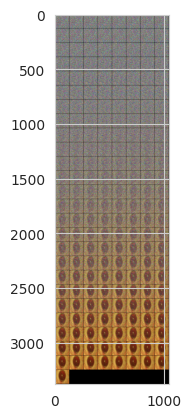

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

xs_chain_cat = torch.cat(xs_chain, dim=0)
xs_grid = make_grid(xs_chain_cat)
plt.imshow(xs_grid.permute(1, 2, 0).cpu())

for t, x_t in enumerate(reversed(xs_chain)):
    x_t = F.interpolate(x_t, size=TARGET_SHAPE[1:], mode='bilinear')
    x_t = (x_t * 255.).type(torch.uint8).squeeze(0)
    x_t = x_t.permute(1, 2, 0).cpu().numpy()

    im = Image.fromarray(x_t)
    im.save(os.path.join(TARGET_PATH + f"t_{t}.png"))

#gen_sample = F.interpolate(gen_chain,
#                           size=TARGET_SHAPE[1:],
#                           mode='bilinear')
#gen_sample = (gen_sample + 1.0) * 0.5
#gen_sample = (gen_sample * 255).type(torch.uint8).to(DEV)



## Fixed condition

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
from lib.utils.misc import label_names_to_vectors, label_vectors_to_names

In [20]:
def sampling(phase_label: torch.Tensor, tool_label: torch.Tensor, steps: int, target_path: str, guidance: float=1.0):
    for i, (_, _, _, yp, ys) in enumerate(tqdm(test_dl)):
        with torch.no_grad():

            if i == steps:
                break


            x = torch.randn(
                BATCH_SIZE,
                *eval(data_conf['SHAPE']),
                device=DEV,
            )

            gen = diffusion.sample_image(x=x,
                                         model=m,
                                         guidance=True,
                                         guidance_strength=guidance,
                                         phase_label=phase_label,
                                         semantic_label=tool_label,
                                         last=True)

            gen = (gen + 1.) * .5

            gen = F.interpolate(gen, size=TARGET_SHAPE[1:], mode='bilinear')
            gen = (gen * 255.).type(torch.uint8).squeeze(0)
            gen = gen.permute(1, 2, 0).cpu().numpy()

            im = Image.fromarray(gen)
            phase, toolset = label_vectors_to_names(test_ds, phase_label, tool_label)
            phase = phase.replace("/", "")
            if tool_label is None:
                im.save(os.path.join(target_path + f"{phase}_ω{guidance}_sample{i}.png"))
            else:
                toolset = toolset.replace("/", "")
                im.save(os.path.join(target_path + f"{phase}_{toolset}_ω{guidance}_sample{i}.png"))

In [8]:
phase = 'Nucleus Breaking'
toolset = ['Phacoemulsifier Handpiece', 'Bonn Forceps']
phase_label, tool_label = label_names_to_vectors(phase, toolset, test_ds)
phase_label, tool_label = phase_label.long().to(DEV), tool_label.float().to(DEV)
sampling(phase_label, tool_label, steps=10, target_path=TARGET_PATH, guidance=2.0)

  0%|          | 0/8873 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  6.86it/s]
2it [00:00,  7.12it/s]
3it [00:00,  7.39it/s]
4it [00:00,  7.59it/s]
5it [00:00,  7.70it/s]
6it [00:00,  7.72it/s]
7it [00:00,  7.78it/s]
8it [00:01,  7.81it/s]
9it [00:01,  7.80it/s]
10it [00:01,  7.78it/s]
11it [00:01,  7.80it/s]
12it [00:01,  7.81it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.73it/s]
15it [00:01,  7.78it/s]
16it [00:02,  7.72it/s]
17it [00:02,  7.73it/s]
18it [00:02,  7.77it/s]
19it [00:02,  7.90it/s]
20it [00:02,  7.52it/s]
21it [00:02,  7.53it/s]
22it [00:02,  7.45it/s]
23it [00:03,  7.40it/s]
24it [00:03,  7.49it/s]
25it [00:03,  7.59it/s]
26it [00:03,  7.69it/s]
27it [00:03,  7.69it/s]
28it [00:03,  7.76it/s]
29it [00:03,  7.91it/s]
30it [00:03,  7.73it/s]
31it [00:04,  7.78it/s]
32it [00:04,  7.81it/s]
33it [00:04,  7.90it/s]
34it [00:04,  7.97it/s]
35it [00:04,  8.03it/s]
36it [00:04,  8.06it/s]
37it [00:04,  8.03it/s]
38it [00:04,  8.05it/s]
39it [00:05,  8.07it/s]
40it [00:05, 

In [10]:
phase = 'Implant Ejection'
toolset = ['Capsulorhexis Forceps', 'Bonn Forceps']
phase_label, tool_label = label_names_to_vectors(phase, toolset, test_ds)
phase_label, tool_label = phase_label.long().to(DEV), tool_label.float().to(DEV)
sampling(phase_label, tool_label, steps=10, target_path=TARGET_PATH, guidance=2.0)

  0%|          | 0/8873 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.59it/s]
2it [00:00,  7.62it/s]
3it [00:00,  7.66it/s]
4it [00:00,  7.68it/s]
5it [00:00,  7.30it/s]
6it [00:00,  6.54it/s]
7it [00:01,  6.43it/s]
8it [00:01,  6.28it/s]
9it [00:01,  6.55it/s]
10it [00:01,  6.35it/s]
11it [00:01,  5.97it/s]
12it [00:01,  6.14it/s]
13it [00:01,  6.54it/s]
14it [00:02,  6.84it/s]
15it [00:02,  7.08it/s]
16it [00:02,  6.97it/s]
17it [00:02,  6.36it/s]
18it [00:02,  6.44it/s]
19it [00:02,  6.44it/s]
20it [00:02,  6.79it/s]
21it [00:03,  6.46it/s]
22it [00:03,  6.83it/s]
23it [00:03,  7.18it/s]
24it [00:03,  7.47it/s]
25it [00:03,  7.71it/s]
26it [00:03,  7.86it/s]
27it [00:03,  7.86it/s]
28it [00:04,  7.95it/s]
29it [00:04,  8.08it/s]
30it [00:04,  8.11it/s]
31it [00:04,  8.13it/s]
32it [00:04,  8.17it/s]
33it [00:04,  8.19it/s]
34it [00:04,  8.23it/s]
35it [00:04,  8.23it/s]
36it [00:04,  8.23it/s]
37it [00:05,  8.27it/s]
38it [00:05,  8.22it/s]
39it [00:05,  7.05it/s]
40it [00:05, 

In [14]:
phase = 'Suturing'
toolset = ['Vannas Scissors', 'Needle Holder']
phase_label, tool_label = label_names_to_vectors(phase, toolset, test_ds)
phase_label, tool_label = phase_label.long().to(DEV), tool_label.float().to(DEV)
sampling(phase_label, tool_label, steps=10, target_path=TARGET_PATH, guidance=2.0)

  0%|          | 0/8873 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  6.79it/s]
2it [00:00,  7.10it/s]
3it [00:00,  7.31it/s]
4it [00:00,  7.47it/s]
5it [00:00,  7.61it/s]
6it [00:00,  7.65it/s]
7it [00:00,  7.68it/s]
8it [00:01,  7.70it/s]
9it [00:01,  7.72it/s]
10it [00:01,  7.73it/s]
11it [00:01,  7.73it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.68it/s]
14it [00:01,  7.67it/s]
15it [00:01,  7.69it/s]
16it [00:02,  7.77it/s]
17it [00:02,  7.86it/s]
18it [00:02,  7.87it/s]
19it [00:02,  7.92it/s]
20it [00:02,  7.99it/s]
21it [00:02,  8.07it/s]
22it [00:02,  7.95it/s]
23it [00:02,  8.01it/s]
24it [00:03,  8.08it/s]
25it [00:03,  8.13it/s]
26it [00:03,  8.14it/s]
27it [00:03,  8.19it/s]
28it [00:03,  8.18it/s]
29it [00:03,  8.18it/s]
30it [00:03,  8.04it/s]
31it [00:03,  8.07it/s]
32it [00:04,  8.11it/s]
33it [00:04,  8.14it/s]
34it [00:04,  8.11it/s]
35it [00:04,  8.10it/s]
36it [00:04,  8.14it/s]
37it [00:04,  8.14it/s]
38it [00:04,  8.14it/s]
39it [00:04,  8.13it/s]
40it [00:05, 

## Sample from every phase

In [21]:
import gc
gc.collect()
torch.cuda.empty_cache()
for yp in range(10, test_ds.num_phases_classes):
    sampling(phase_label=torch.tensor([yp]).view(1, 1), tool_label=None, steps=10, target_path=os.path.join(LOG_PATH, "eval/gen_samples3/"), guidance=2.0)


  0%|          | 0/8873 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.57it/s]
2it [00:00,  7.47it/s]
3it [00:00,  7.49it/s]
4it [00:00,  7.48it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.35it/s]
7it [00:00,  7.36it/s]
8it [00:01,  7.42it/s]
9it [00:01,  7.43it/s]
10it [00:01,  7.39it/s]
11it [00:01,  7.41it/s]
12it [00:01,  7.42it/s]
13it [00:01,  7.42it/s]
14it [00:01,  7.34it/s]
15it [00:02,  7.33it/s]
16it [00:02,  7.37it/s]
17it [00:02,  7.40it/s]
18it [00:02,  7.39it/s]
19it [00:02,  7.48it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.65it/s]
22it [00:02,  7.23it/s]
23it [00:03,  7.32it/s]
24it [00:03,  7.10it/s]
25it [00:03,  6.98it/s]
26it [00:03,  7.22it/s]
27it [00:03,  6.94it/s]
28it [00:03,  7.19it/s]
29it [00:03,  7.39it/s]
30it [00:04,  7.48it/s]
31it [00:04,  7.53it/s]
32it [00:04,  7.64it/s]
33it [00:04,  7.71it/s]
34it [00:04,  7.23it/s]
35it [00:04,  7.36it/s]
36it [00:04,  7.23it/s]
37it [00:05,  7.34it/s]
38it [00:05,  7.44it/s]
39it [00:05,  7.56it/s]
40it [00:05, 